## V4L2应用编程
### 什么是v4l2

v4l2是video for Linux 2的缩写，是一套Linux内核视频设备的驱动框架，该驱动框架为应用层提供一套统一的操作接口(一系列的ioctl)。V4L2在设计时，是要支持很多广泛的设备的，它们之中只有一部分在本质上是真正的视频设备，可以支持多种设备,它可以有以下几种接口：

**video capture interface**：视频采集接口，这种接口应用于摄像头，v4l2在最初设计的时候就是应用于这种功能。

**video output interface**：视频输出接口，将静止图像或图像序列编码为模拟视频信号，通过此接口，应用程序可以控制编码过程并将图像==从用户空间移动到驱动程序。

**video overlay interface**：视频直接传输接口，可以将采集到的视频数据直接传输到显示设备，不需要cpu参与，这种方式的显示图像的效率比其他方式高得多。

### 重要API

*   打开设备
*   更改设备属性，选择视频和音频输入，视频标准，图片亮度等
*   设置数据格式
*   设置输入/输出方法
*   输入输出缓存队列循环
*   关闭设备

其中大多数操作都是通过应用层调用`ioctl`实现的，可以将这些ioctl分为下面几类

（1）Querying Capabilitues：查询设备功能

由于V4L2涵盖了各种各样的设备，因此并非API的所有方面都适用于所有类型的设备，在使用v4l2设备时，必须调用此API，获得设备支持的功能（capture、output、overlay…）

| ID   | 描述 |
| ------ | ---- | 
| VIDIOC_QUERYCAP   | 查询设备功能   |  

（2）Application Priority：**应用优先级**

当多个应用程序共享设备时，可能需要为它们分配不同的优先级。视频录制应用程序可以例如阻止其他应用程序改变视频控制或切换当前的电视频道。另一个目标是允许在后台工作的低优先级应用程序，这些应用程序可以被用户控制的应用程序抢占，并在以后自动重新获得对设备的控制.

| ID   | 描述 |
| ------ | ---- | 
| VIDIOC_G_PRIORITY   | 获取优先级   |  
| VIDIOC_G_PRIORITY   | 设置优先级   |  

（3）Device Inputs and Outputs：输入和输出设备

| ID                | 描述                   |
| ----------------- | ---------------------- |
| VIDIOC_ENUMINPUT  | 枚举视频输入设备       |
| VIDIOC_G_INPUT    | 获取当前的视频输入设备 |
| VIDIOC_S_INPUT    | 设置视频输入设备       |
| VIDIOC_ENUMOUTPUT | 枚举视频输出设备       |
| VIDIOC_G_OUTPUT   | 获取当前视频输出设备   |
| VIDIOC_S_OUTPUT   | 设置视频输出设备       |
| VIDIOC_ENUMAUDIO  | 枚举音频输入设备       |
| VIDIOC_G_AUDIO    | 获取当前音频输入设备   |
| VIDIOC_S_AUDIO    | 设置音频输入设备       |
| VIDIOC_ENUMAUDOUT | 枚举音频输出设备       |
| VIDIOC_G_AUDOUT   | 获取音频输出设备       |
| VIDIOC_S_AUDOUT   | 设置音频输出设备       |

（4）Video Standards：**视频标准**

| ID               | 描述                                |
| ---------------- | ----------------------------------- |
| VIDIOC_ENUMSTD   | 枚举设备支持的所有标准               |
| VIDIOC_G_STD     | 获取当前正在使用的标准               |
| VIDIOC_S_STD     | 设置视频标准                         |
| VIDIOC_QUERYSTD  | 有的设备支持自动侦测输入源的视频标准，此 ioctl 获取检测到的标准 |

（5） Camera Control Reference：**控制属性**

| ID                | 描述                                |
| ----------------- | ----------------------------------- |
| VIDIOC_ENUMSTD    | 枚举设备支持的所有标准               |
| VIDIOC_G_STD      | 获取当前正在使用的标准               |
| VIDIOC_S_STD      | 设置视频标准                         |
| VIDIOC_QUERYSTD   | 有的设备支持自动侦测输入源的视频标准，此 ioctl 获取检测到的标准 |
| VIDIOC_QUERYCTRL  | 查询指定的 control 详细信息         |
| VIDIOC_QUERYMENU  | 查询 menu                           |
| VIDIOC_G_CTRL     | 获取设备指定 control 的当前信息      |
| VIDIOC_S_CTRL     | 设置设备指定的 control               |

（6）Image Format：**图像格式**

图像由多种格式YUV和RGB还有压缩格式等等，其中每种格式又分有多种格式，比如RGB：RGB565、RGB888…所以在使用设备时，需要对格式进行设置

| ID             | 描述                    |
| -------------- | ----------------------- |
| VIDIOC_ENUM_FMT| 枚举设备支持的图像格式  |
| VIDIOC_G_FMT   | 获取当前设备的图像格式  |
| VIDIOC_S_FMT   | 设置图像格式            |
| VIDIOC_TRY_FMT | 测试设备是否支持此格式  |

（7）Cropping, composing and scaling：**图像裁剪、插入与缩放**

| ID             | 描述                      |
| -------------- | ------------------------- |
| VIDIOC CROPCAP | 获取图像裁剪缩放能力       |
| VIDIOC G CROP  | 获取当前的裁剪矩阵         |
| VIDIOC S CROP  | 设置裁剪矩阵               |

（8） Input/Output：**数据的输入和输出**

内核中使用缓存队列对图像数据进行管理，用户空间获取图像数据有两种方式，一种是通过read、write方式读取内核空间的缓存，一种是将内核空间的缓存映射到用户空间。在操作v4l2设备时，通过[VIDIOC\_QUERYCAP](https://www.kernel.org/doc/html/latest/media/uapi/v4l/vidioc-querycap.html#vidioc-querycap)获取设备支持哪种方式。

| ID             | 描述                    |
| -------------- | ----------------------- |
| VIDIOC REQBUFS | 申请缓存                |
| VIDIOC QUERYBUF| 获取缓存信息            |
| VIDIOC QBUF    | 将缓存放入队列中        |
| VIDIOC DQBUF   | 将缓存从队列中取出      |

















### v4L2设备操作流程

V4L2支持多种接口：`capture(捕获)`、`output(输出)`、`overlay(预览)`等等

这里讲解如何使用`capture`功能，下面讲解操作流程：

#### step1 打开设备
在Linux中，视频设备节点为`/dev/videox`，使用open函数将其打开：

```c
int fd = open(name, flag);
if(fd < 0)
{
	printf("ERR(%s):failed to open %s\n", __func__, name);
    return -1;
}

return fd;
```
#### step 2：查询设备功能

```c
if (ioctl(fd, VIDIOC_QUERYCAP, cap) < 0)
{
    printf("ERR(%s):VIDIOC_QUERYCAP failed\n", __func__);
    return -1;
}
```
看一看`v4l2_capability`
```c
struct v4l2_capability {
	__u8	driver[16];	/* i.e. "bttv" */
	__u8	card[32];	/* i.e. "Hauppauge WinTV" */
	__u8	bus_info[32];	/* "PCI:" + pci_name(pci_dev) */
	__u32   version;        /* should use KERNEL_VERSION() */
	__u32	capabilities;	/* Device capabilities */
	__u32	reserved[4];
};
```

其中最重要的是`capabilities`字段，这个字段标记着v4l2设备的功能，`capabilities`有以下部分标记位.

| ID                    | 描述符                   |
| --------------------- | ------------------------ |
| V4L2_CAP_VIDEO_CAPTURE| 设备支持捕获功能          |
| V4L2_CAP_VIDEO_OUTPUT | 设备支持输出功能          |
| V4L2_CAP_VIDEO_OVERLAY| 设备支持预览功能          |
| V4L2_CAP_STREAMING    | 设备支持流读写            |
| V4L2_CAP_READWRITE    | 设备支持 read、write 方式读写 |

我们可以通过这样子去判断设备的功能：

```c
if(cap.capabilities & V4L2_CAP_VIDEO_CAPTURE)
    printf("v4l2 dev support capture\n");

if(cap.capabilities & V4L2_CAP_VIDEO_OUTPUT)
    printf("v4l2 dev support output\n");

if(cap.capabilities & V4L2_CAP_VIDEO_OVERLAY)
    printf("v4l2 dev support overlay\n");

if(cap.capabilities & V4L2_CAP_STREAMING)
    printf("v4l2 dev support streaming\n");

if(cap.capabilities & V4L2_CAP_READWRITE)
    printf("v4l2 dev support read write\n");
```

#### step 3：设置输入设备
一个设备可能有多个输入，比如：在芯片上，摄像头控制器和摄像头接口是分离的，需要选择哪一个摄像头接口作为摄像头控制器的输入源。

当然，并不是所有的设备都需要设置输入，比如：uvc摄像头，一般只有一个输入，默认就会选择，不需要设置

下面介绍如何设置输入设备:

*  1.枚举输入设备

下面这段程序枚举了该设备所有的输入源，并打印输入源的名称。

```c
struct v4l2_input input;

input.index = 0;
while (!ioctl(fd, VIDIOC_ENUMINPUT, &input))
{
    printf("input:%s\n", input.name);
    ++input.index;
}
```
*  2.设置输入设备

```c
struct v4l2_input input;

input.index = index; //指定输入设备

if (ioctl(fd, VIDIOC_S_INPUT, &input) < 0)
{
    printf("ERR(%s):VIDIOC_S_INPUT failed\n", __func__);
    return -1;
}
```
#### step 4：设置图像格式

有的摄像头支持多种像素格式，有的摄像头只支持一种像素格式，在设置格式之前，要先枚举出所有的格式，看一看是否支持要设置的格式，然后再进一步设置。
*  枚举支持的像素格式

```c
struct v4l2_fmtdesc fmtdesc;

fmtdesc.type = V4L2_BUF_TYPE_VIDEO_CAPTURE;
fmtdesc.index = 0;

while (!ioctl(fd, VIDIOC_ENUM_FMT, &fmtdesc))
{
    printf("fmt:%s\n", fmtdesc.description);

    fmtdesc.index++;
}
```

*  设置像素格式

```c
struct v4l2_format v4l2_fmt;

memset(&v4l2_fmt, 0, sizeof(struct v4l2_format));
v4l2_fmt.type = V4L2_BUF_TYPE_VIDEO_CAPTURE; 
v4l2_fmt.fmt.pix.width = width; //宽度
v4l2_fmt.fmt.pix.height = height; //高度
v4l2_fmt.fmt.pix.pixelformat = V4L2_PIX_FMT_YUYV; //像素格式
v4l2_fmt.fmt.pix.field = V4L2_FIELD_ANY;

if (ioctl(fd, VIDIOC_S_FMT, &v4l2_fmt) < 0)
{
    printf("ERR(%s):VIDIOC_S_FMT failed\n", __func__);
    return -1;
}
```

#### step 5：设置缓存

v4l2设备读取数据的方式有两种，一种是read方式，一种是streaming方式，具体需要看`step 2`的返回结果是支持`V4L2_CAP_READWRITE`还是`V4L2_CAP_STREAMING`

read方式很容易理解，就是通过read函数读取，那么streaming是什么意思呢？

streaming就是在内核空间中维护一个`缓存队列`，然后将内存`映射`到用户空间，应用读取图像数据就是一个不断地`出队列`和`入队列`的过程，如下图所示：

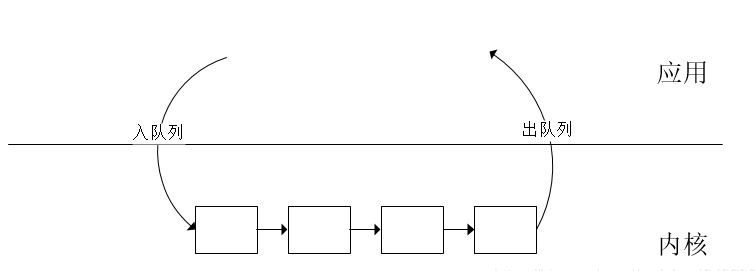

如何去申请和映射缓存？

*  申请缓存

```c
struct v4l2_requestbuffers req;

req.count = nr_bufs; //缓存数量
req.type = V4L2_BUF_TYPE_VIDEO_CAPTURE;
req.memory = V4L2_MEMORY_MMAP;

if (ioctl(fd, VIDIOC_REQBUFS, &req) < 0)
{
    printf("ERR(%s):VIDIOC_REQBUFS failed\n", __func__);
    return -1;
}
```
*  映射缓存

为什么要映射缓存？

因为如果使用read方式读取的话，图像数据是从内核空间拷贝会应用空间，而一副图像的数据一般来讲是比较大的，所以效率会比较低。而如果使用映射的方式，讲内核空间的内存应用到用户空间，那么用户空间读取数据就想在操作内存一样，不需要经过内核空间到用户空间的拷贝，大大提高效率。

映射缓存需要先查询缓存信息，然后再使用缓存信息进行映射，下面是一个例：

```c
struct v4l2_buffer v4l2_buffer;
void* addr;

memset(&v4l2_buffer, 0, sizeof(struct v4l2_buffer));
v4l2_buffer.index = i; //想要查询的缓存
v4l2_buffer.type = V4L2_BUF_TYPE_VIDEO_CAPTURE;
v4l2_buffer.memory = V4L2_MEMORY_MMAP;

/* 查询缓存信息 */
ret = ioctl(fd, VIDIOC_QUERYBUF, &v4l2_buffer);
if(ret < 0)
{
    printf("Unable to query buffer.\n");
    return -1;
}

/* 映射 */
addr = mmap(NULL /* start anywhere */ ,
            v4l2_buffer.length, PROT_READ | PROT_WRITE, MAP_SHARED,
            fd, v4l2_buffer.m.offset);
```

**注**：需要将所有申请的缓存使用上述方法进行映射

*  3.将所有的缓存放入队列

```c
struct v4l2_buffer v4l2_buffer;

for(i = 0; i < nr_bufs; i++)
{
	memset(&v4l2_buffer, 0, sizeof(struct v4l2_buffer));
	v4l2_buffer.index = i; //想要放入队列的缓存
	v4l2_buffer.type = V4L2_BUF_TYPE_VIDEO_CAPTURE;
	v4l2_buffer.memory = V4L2_MEMORY_MMAP;	

    ret = ioctl(fd, VIDIOC_QBUF, &v4l2_buffer);
    if(ret < 0)
    {
        printf("Unable to queue buffer.\n");
        return -1;
    }
}       
```

#### step 6：打开设备

```c
enum v4l2_buf_type type = V4L2_BUF_TYPE_VIDEO_CAPTURE;

if (ioctl(fd, VIDIOC_STREAMON, &type) < 0)
{
    printf("ERR(%s):VIDIOC_STREAMON failed\n", __func__);
    return -1;
}       
```
#### step 7：读取数据

获取图像数据其实就是一个不断地入队列和出队列地过程，在出队列前要调用`poll`等待数据准备完成。

*  poll
```c
struct pollfd poll_fds[1];

poll_fds[0].fd = fd;
poll_fds[0].events = POLLIN; //等待可读

poll(poll_fds, 1, 10000);       
```

*  出队列

```c
struct v4l2_buffer buffer;

buffer.type = V4L2_BUF_TYPE_VIDEO_CAPTURE;
buffer.memory = V4L2_MEMORY_MMAP;

if (ioctl(fd, VIDIOC_DQBUF, &buffer) < 0)
{
    printf("ERR(%s):VIDIOC_DQBUF failed, dropped frame\n", __func__);
    return -1;
}     
```
出队列后得到了缓存的下标`buffer.index`，然后找到对应的缓存，通过映射过后的地址进行数据的读取,

* 入队列
再数据读取完成后，要将buf重新放入队列中。

```c
struct v4l2_buffer v4l2_buf;

v4l2_buf.type = V4L2_BUF_TYPE_VIDEO_CAPTURE;
v4l2_buf.memory = V4L2_MEMORY_MMAP;
v4l2_buf.index = i; //指定buf

if (ioctl(fd, VIDIOC_QBUF, &v4l2_buf) < 0)
{
    printf("ERR(%s):VIDIOC_QBUF failed\n", __func__);
    return -1;
}      
```
读取数据就是在上面这三步一直不断地循环。

#### step 8：关闭设备
 
*  1.关闭设备

```c
enum v4l2_buf_type type = V4L2_BUF_TYPE_VIDEO_CAPTURE;

if (ioctl(fd, VIDIOC_STREAMOFF, &type) < 0)
{
    printf("ERR(%s):VIDIOC_STREAMOFF failed\n", __func__);
    return -1;
}   
```
 *  2.取消映射

 ```c
for(i = 0; i < nr_bufs; ++i)
    munmap(buf[i].addr, buf[i]->length); 
```

*  3.关闭文件描述符

 ```c
close(fd);
```